In [1]:
# Import basic modules
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from scipy.stats import norm

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
merge_data = pd.read_csv('tenant_energy_clean_data.csv')
merge_data['date_time'] = pd.to_datetime(merge_data['date_time'])
merge_data.head()

,date_time,electric_consumption,electric_demand,steam_consumption,steam_demand,temp,humidity,electric_cum_consumption,electric_cum_demand,steam_cum_consumption,...,tenant_17_consumption,tenant_17_demand,tenant_17_cum_consumption,tenant_18_consumption,tenant_18_demand,tenant_18_cum_consumption,all_tenants_consumption,all_tenants_cum_consumption,date,entries
0,2018-01-01 00:15:00,430.0,1720.0,4800.0,18700.0,9.000,56.100,430.0,1720.0,4800.0,...,0.2,1.2,0.2,0.0,0.0,0.0,15.2,15.2,2018-01-01,NaN
1,2018-01-01 00:30:00,420.0,1700.0,4480.0,18560.0,9.000,56.100,850.0,3420.0,9280.0,...,0.2,0.8,0.4,0.0,0.0,0.0,16.0,31.2,2018-01-01,NaN
2,2018-01-01 00:45:00,440.0,1720.0,5350.0,19660.0,9.000,56.100,1290.0,5140.0,14630.0,...,0.4,1.2,0.8,0.2,0.4,0.2,15.5,46.7,2018-01-01,NaN
3,2018-01-01 01:00:00,420.0,1720.0,5660.0,22020.0,9.000,56.100,1710.0,6860.0,20290.0,...,0.4,1.6,1.2,0.0,0.4,0.2,15.3,62.0,2018-01-01,NaN
4,2018-01-01 01:15:00,420.0,1680.0,5660.0,22640.0,8.975,56.125,2130.0,8540.0,25950.0,...,0.2,1.2,1.4,0.0,0.0,0.2,15.3,77.3,2018-01-01,NaN


In [3]:
# time_features
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def date_time_features(date_time):
    date_time['year'] = date_time['date_time'].dt.year
    date_time['month'] = date_time['date_time'].dt.month
    date_time['day'] = date_time['date_time'].dt.day
    date_time['hour'] = date_time['date_time'].dt.hour
    date_time['quater'] = date_time['date_time'].dt.minute.apply(lambda x: 0 if x==0 else 1 if x==15 else 2 if x==30 else 3)
    date_time['weekday'] = date_time['date_time'].dt.weekday
    date_time['is_weekend'] = date_time['date_time'].dt.weekday.apply(lambda x: 1 if x in [5,6] else 0)
    cal = calendar()
    date_time['is_holiday'] = date_time['date_time'].dt.date.astype('datetime64').isin(cal.holidays(start=date_time['date_time'].min(), end=date_time['date_time'].max())).astype(int)
    date_time['daytime_range'] = date_time['date_time'].dt.hour.apply(lambda x: 'Morning' if x in [7,8,9,10,11] else \
                                                                               'Afternoon' if x in [12,13,14,15,16,17] else \
                                                                               'Evening' if x in [18,19,20,21] else
                                                                               'Night')
    date_time['after_032020'] = date_time['date_time'].dt.strftime('%Y-%m-%d').apply(lambda x: 1 if x>='2020-03-20' else 0)
    return date_time

In [4]:
date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-09-01', freq='15T'), columns=['date_time'])
date_time = date_time_features(date_time)
date_time.head()

,date_time,year,month,day,hour,quater,weekday,is_weekend,is_holiday,daytime_range,after_032020
0,2018-01-01 00:15:00,2018,1,1,0,1,0,0,0,Night,0
1,2018-01-01 00:30:00,2018,1,1,0,2,0,0,0,Night,0
2,2018-01-01 00:45:00,2018,1,1,0,3,0,0,0,Night,0
3,2018-01-01 01:00:00,2018,1,1,1,0,0,0,0,Night,0
4,2018-01-01 01:15:00,2018,1,1,1,1,0,0,0,Night,0


In [5]:
merge_data = merge_data.merge(date_time, on='date_time')
merge_data = merge_data.set_index('date_time')
merge_data.head()

,electric_consumption,electric_demand,steam_consumption,steam_demand,temp,humidity,electric_cum_consumption,electric_cum_demand,steam_cum_consumption,steam_cum_demand,...,year,month,day,hour,quater,weekday,is_weekend,is_holiday,daytime_range,after_032020
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,430.0,1720.0,4800.0,18700.0,9.000,56.100,430.0,1720.0,4800.0,18700.0,...,2018,1,1,0,1,0,0,0,Night,0
2018-01-01 00:30:00,420.0,1700.0,4480.0,18560.0,9.000,56.100,850.0,3420.0,9280.0,37260.0,...,2018,1,1,0,2,0,0,0,Night,0
2018-01-01 00:45:00,440.0,1720.0,5350.0,19660.0,9.000,56.100,1290.0,5140.0,14630.0,56920.0,...,2018,1,1,0,3,0,0,0,Night,0
2018-01-01 01:00:00,420.0,1720.0,5660.0,22020.0,9.000,56.100,1710.0,6860.0,20290.0,78940.0,...,2018,1,1,1,0,0,0,0,Night,0
2018-01-01 01:15:00,420.0,1680.0,5660.0,22640.0,8.975,56.125,2130.0,8540.0,25950.0,101580.0,...,2018,1,1,1,1,0,0,0,Night,0


In [6]:
merge_data.columns

Index(['electric_consumption', 'electric_demand', 'steam_consumption',
       'steam_demand', 'temp', 'humidity', 'electric_cum_consumption',
       'electric_cum_demand', 'steam_cum_consumption', 'steam_cum_demand',
       'tenant_1_consumption', 'tenant_1_demand', 'tenant_1_cum_consumption',
       'tenant_2_consumption', 'tenant_2_demand', 'tenant_2_cum_consumption',
       'tenant_3_consumption', 'tenant_3_demand', 'tenant_3_cum_consumption',
       'tenant_4_consumption', 'tenant_4_demand', 'tenant_4_cum_consumption',
       'tenant_5_consumption', 'tenant_5_demand', 'tenant_5_cum_consumption',
       'tenant_6_consumption', 'tenant_6_demand', 'tenant_6_cum_consumption',
       'tenant_7_consumption', 'tenant_7_demand', 'tenant_7_cum_consumption',
       'tenant_8_consumption', 'tenant_8_demand', 'tenant_8_cum_consumption',
       'tenant_9_consumption', 'tenant_9_demand', 'tenant_9_cum_consumption',
       'tenant_10_consumption', 'tenant_10_demand',
       'tenant_10_cum_consump

Linear Regression

In [7]:
#tenant_usage_meters = pd.read_csv('tenant_usage_meters.csv')
#tenant_usage_meters.head()

In [30]:
data_lin = merge_data.copy()
#data_lin['entries'] = data_lin['entries'].interpolate().round()
data_lin['has_entries_data'] = data_lin['entries'].apply(lambda x: 0 if pd.isnull(x) else 1)
#data_lin['has_entries_data'] = data_lin['date_time'].dt.strftime('%Y-%m-%d').apply(lambda x: 0 if x<'2020-02-10' else 1)
data_lin = data_lin[[#'electric_consumption', 'electric_demand', 'electric_cum_consumption', 'electric_cum_demand',  
        #'steam_consumption', 'steam_demand', 'steam_cum_consumption', 'steam_cum_demand', 
        'temp', 'humidity', 'entries', 'has_entries_data',
        #'all_tenants_consumption', 'all_tenants_cum_consumption', 
        'year', 'month', 'day', 'hour', 'quater', 'weekday', 'is_weekend', 'is_holiday', 'daytime_range', #'after_032020',
        'tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption', 'tenant_4_consumption', 
        'tenant_5_consumption', 'tenant_6_consumption', 'tenant_7_consumption', 'tenant_8_consumption', 
        'tenant_9_consumption', 'tenant_10_consumption', 'tenant_11_consumption', 'tenant_12_consumption', 
        'tenant_13_consumption', 'tenant_14_consumption', 'tenant_15_consumption', 'tenant_16_consumption', 
        'tenant_17_consumption', 'tenant_18_consumption']]

cat_cols = ['year', 'month', 'hour', 'quater', 'weekday', 'is_weekend', 'is_holiday', 'daytime_range']
for col in cat_cols:
    data_lin[col] = data_lin[col].astype('category')
data_lin = pd.get_dummies(data_lin)
    
data_lin.head()

,temp,humidity,entries,has_entries_data,day,tenant_1_consumption,tenant_2_consumption,tenant_3_consumption,tenant_4_consumption,tenant_5_consumption,...,weekday_5,weekday_6,is_weekend_0,is_weekend_1,is_holiday_0,is_holiday_1,daytime_range_Afternoon,daytime_range_Evening,daytime_range_Morning,daytime_range_Night
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,9.000,56.100,NaN,0,1,0.4,1.6,0.2,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 00:30:00,9.000,56.100,NaN,0,1,0.4,1.6,0.2,1.3,0.5,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 00:45:00,9.000,56.100,NaN,0,1,0.4,1.5,0.2,1.3,0.4,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 01:00:00,9.000,56.100,NaN,0,1,0.3,1.6,0.2,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 01:15:00,8.975,56.125,NaN,0,1,0.4,1.5,0.3,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1


In [31]:
data_lin.columns

Index(['temp', 'humidity', 'entries', 'has_entries_data', 'day',
       'tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption',
       'tenant_4_consumption', 'tenant_5_consumption', 'tenant_6_consumption',
       'tenant_7_consumption', 'tenant_8_consumption', 'tenant_9_consumption',
       'tenant_10_consumption', 'tenant_11_consumption',
       'tenant_12_consumption', 'tenant_13_consumption',
       'tenant_14_consumption', 'tenant_15_consumption',
       'tenant_16_consumption', 'tenant_17_consumption',
       'tenant_18_consumption', 'year_2018', 'year_2019', 'year_2020',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', '

In [134]:
df = data_lin.fillna(0)
df = df[df.index<='2020-08-30 23:45:00']

test_size = 0.15
test_index = int(len(df)*(1-test_size))

scaler = StandardScaler()
#df[['electric_consumption', 'electric_demand', 'steam_consumption', 'steam_demand']] = scaler.fit_transform(df[['electric_consumption', 'electric_demand', 'steam_consumption', 'steam_demand']])

tenant_cols = ['tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption', 'tenant_4_consumption', 
            'tenant_5_consumption', 'tenant_6_consumption', 'tenant_7_consumption', 'tenant_8_consumption', 
            'tenant_9_consumption', 'tenant_10_consumption', 'tenant_11_consumption', 'tenant_12_consumption', 
            'tenant_13_consumption', 'tenant_14_consumption', 'tenant_15_consumption', 'tenant_16_consumption', 
            'tenant_17_consumption', 'tenant_18_consumption']
X_train = df.drop(tenant_cols, axis = 1).iloc[:test_index]
y_train = df[tenant_cols].iloc[:test_index]
X_test = df.drop(tenant_cols, axis = 1).iloc[test_index:]
y_test = df[tenant_cols].iloc[test_index:]

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [135]:
y_test.shape

(14012, 18)

In [136]:
y_test.columns

Index(['tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption',
       'tenant_4_consumption', 'tenant_5_consumption', 'tenant_6_consumption',
       'tenant_7_consumption', 'tenant_8_consumption', 'tenant_9_consumption',
       'tenant_10_consumption', 'tenant_11_consumption',
       'tenant_12_consumption', 'tenant_13_consumption',
       'tenant_14_consumption', 'tenant_15_consumption',
       'tenant_16_consumption', 'tenant_17_consumption',
       'tenant_18_consumption'],
      dtype='object')

In [137]:
def error(y_test, y_predict, expm1=True):
    if expm1:
        y_test = np.expm1(y_test)
        y_predict = np.expm1(y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    std = np.std(y_predict)
    return rmse.round(6), std.round(6)

In [138]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
error(y_test, y_predict)

(0.497258, 0.875176)

In [139]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.15, normalize=True) 
ridge.fit(X_train, y_train)
y_predict = ridge.predict(X_test)
error(y_test, y_predict)

(0.487758, 0.84148)

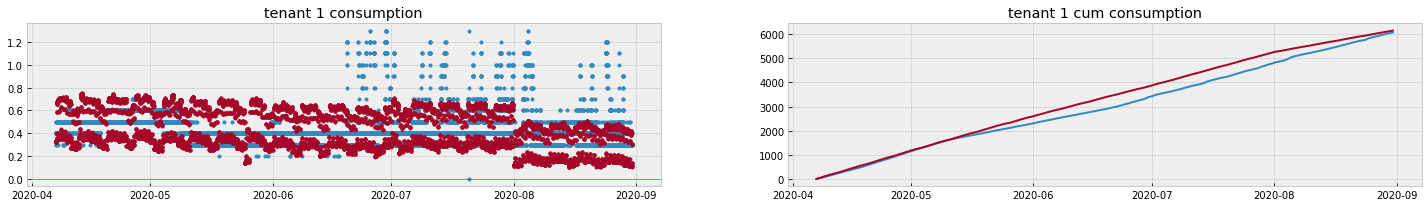

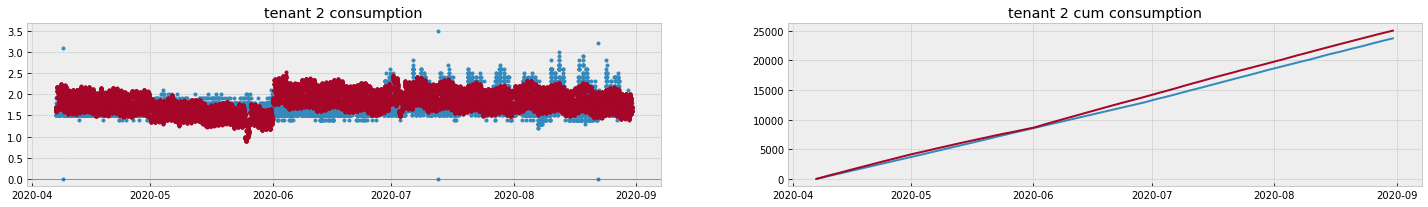

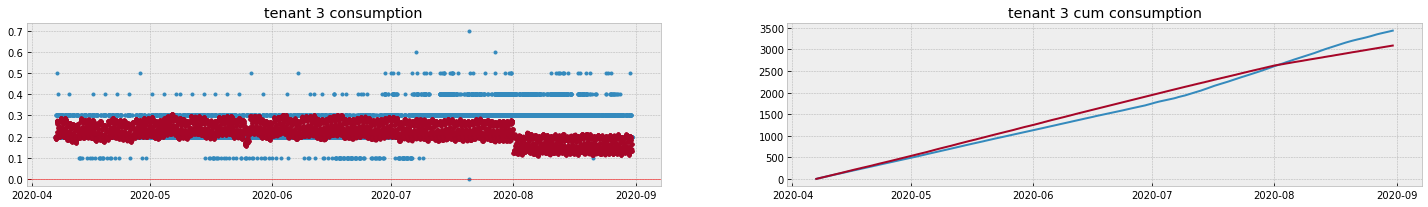

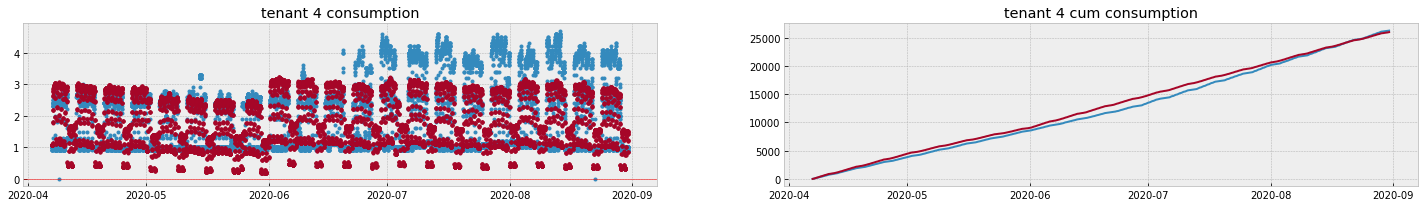

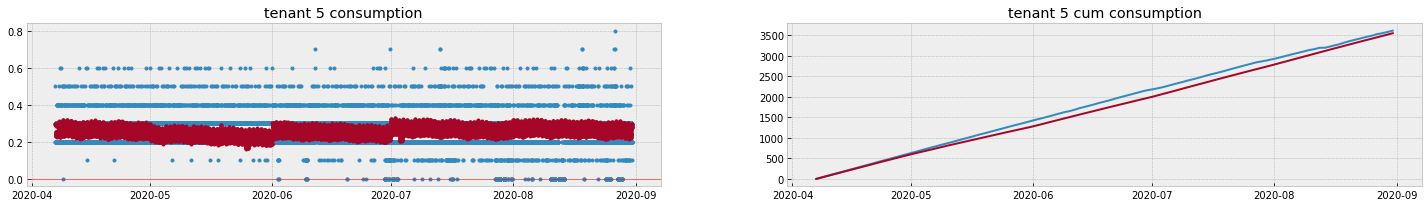

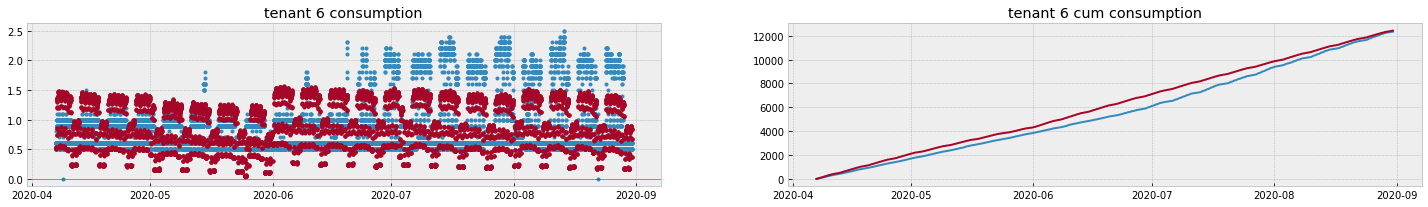

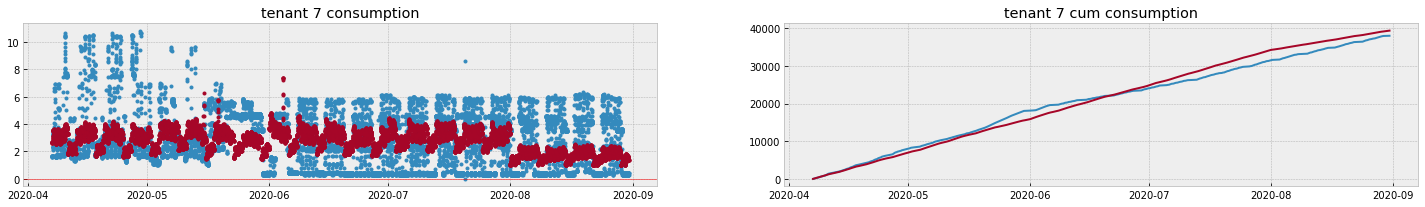

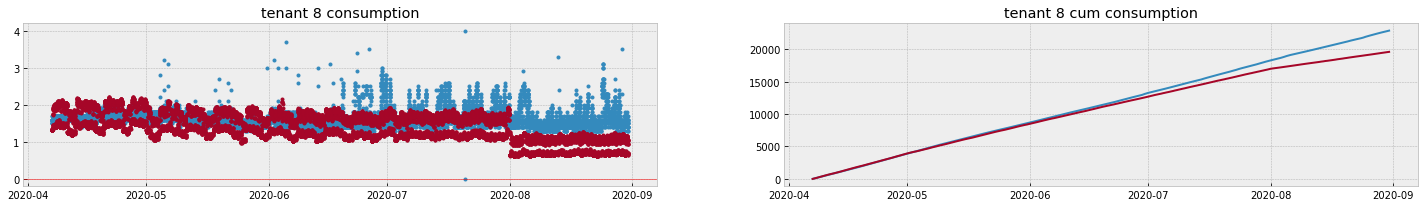

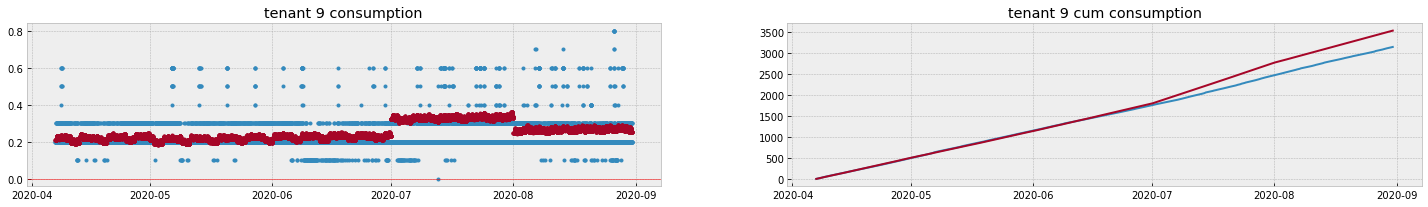

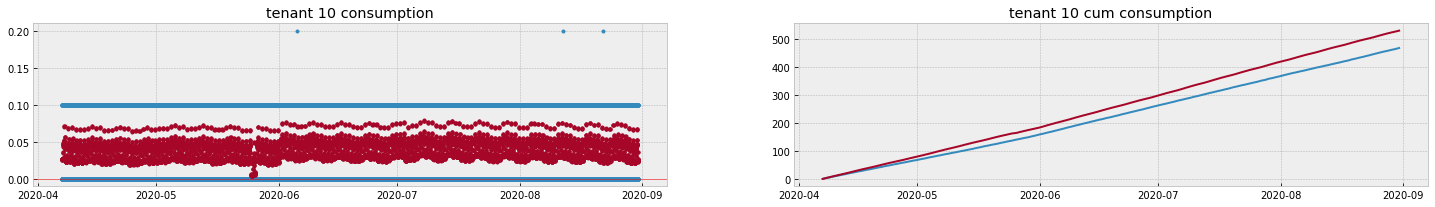

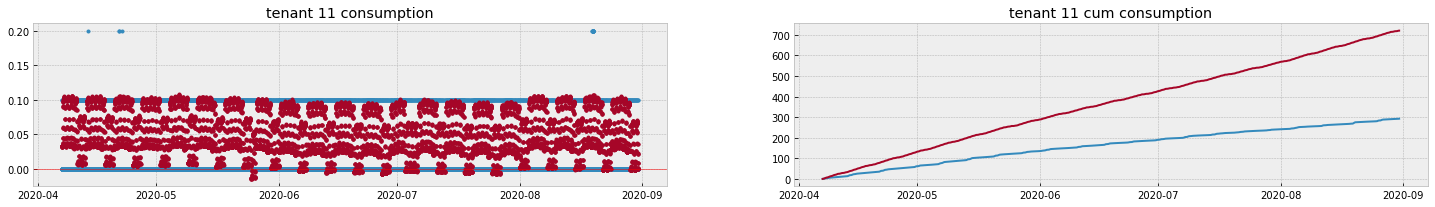

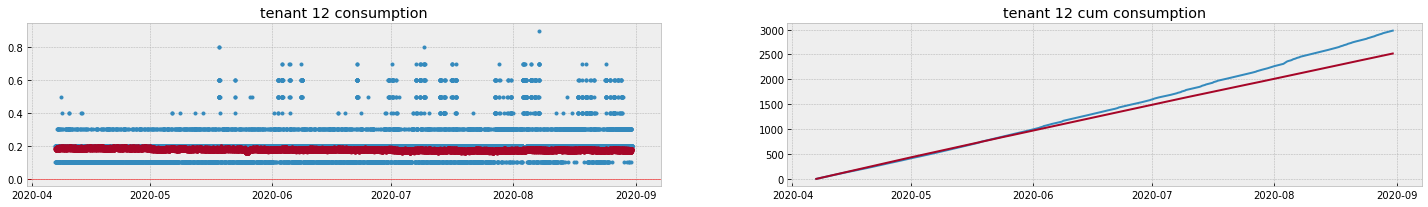

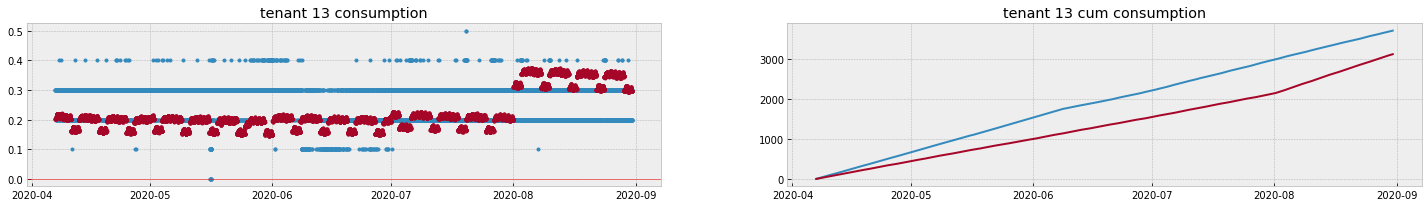

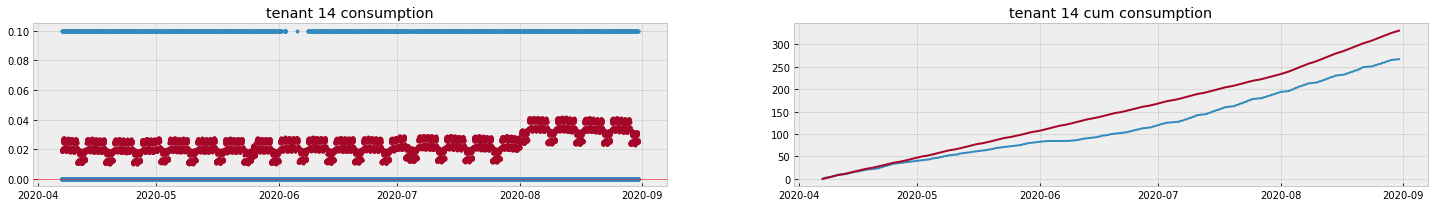

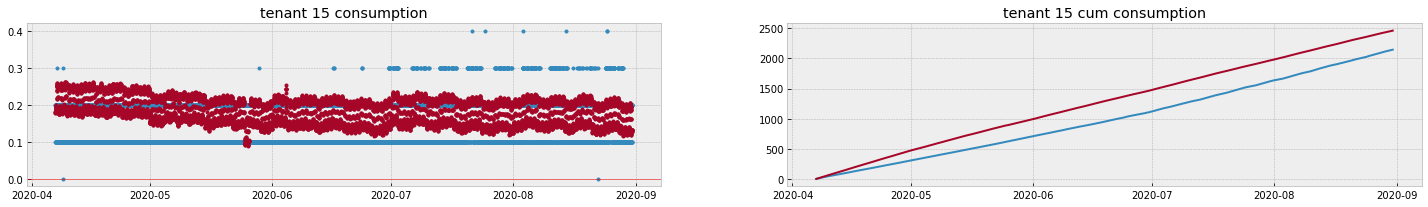

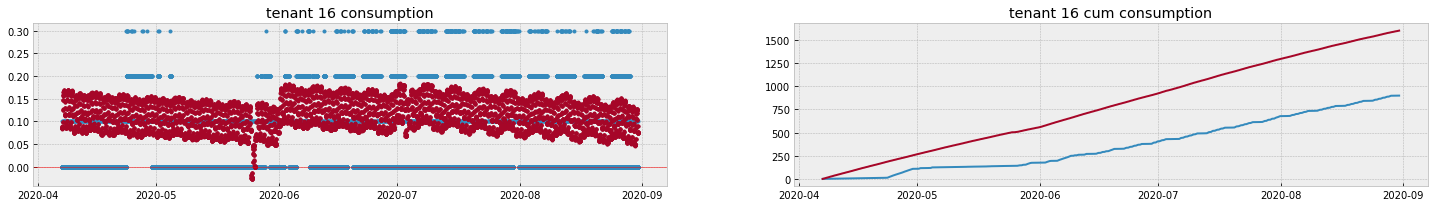

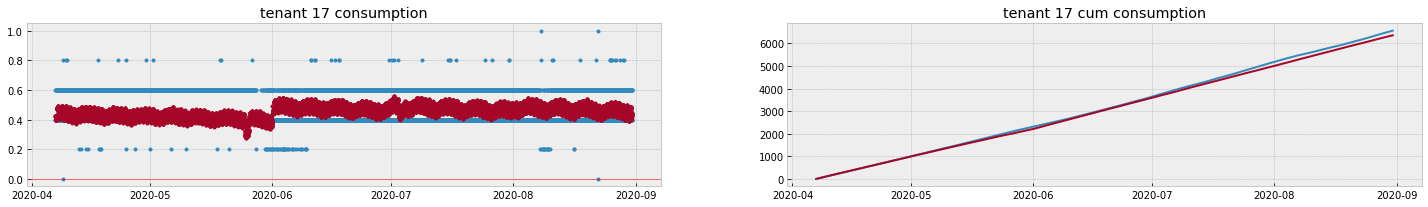

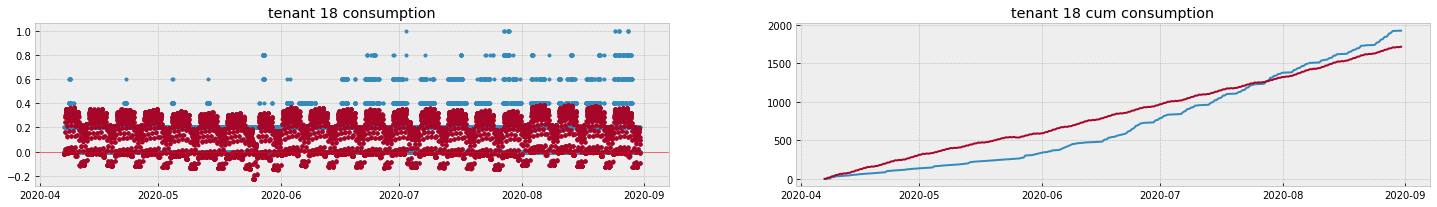

In [140]:
for i in range(18):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 3))
    ax1.plot(X_test.index, np.expm1(y_test.iloc[:,i]), '.')
    ax1.plot(X_test.index, np.expm1(y_predict[:,i]), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title('tenant '+str(i+1)+' consumption')

    ax2.plot(X_test.index, np.expm1(y_test.iloc[:,i]).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict[:,i]).cumsum(), '-')
    ax2.set_title('tenant '+str(i+1)+' cum consumption') 
    plt.show()

In [141]:
'''plt.figure(figsize = (20, 6))
plt.plot(range(len(X_train.columns)), ridge.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
#plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('coefficients')
plt.ylabel('coeff')
plt.xlabel('Features')
plt.show()'''

"plt.figure(figsize = (20, 6))\nplt.plot(range(len(X_train.columns)), ridge.coef_)\nplt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)\n#plt.margins(0.02)\nplt.axhline(0, linewidth = 0.5, color = 'r')\nplt.title('coefficients')\nplt.ylabel('coeff')\nplt.xlabel('Features')\nplt.show()"

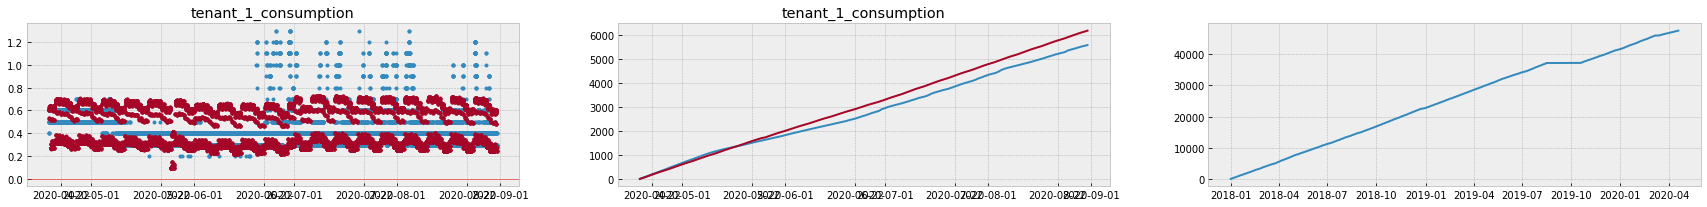

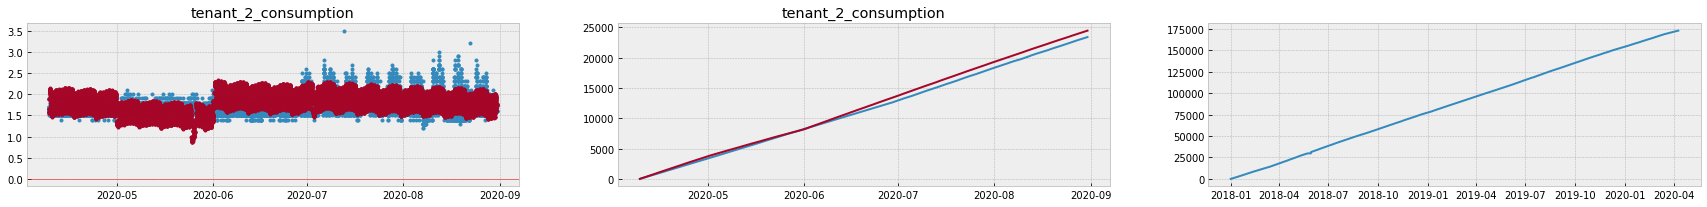

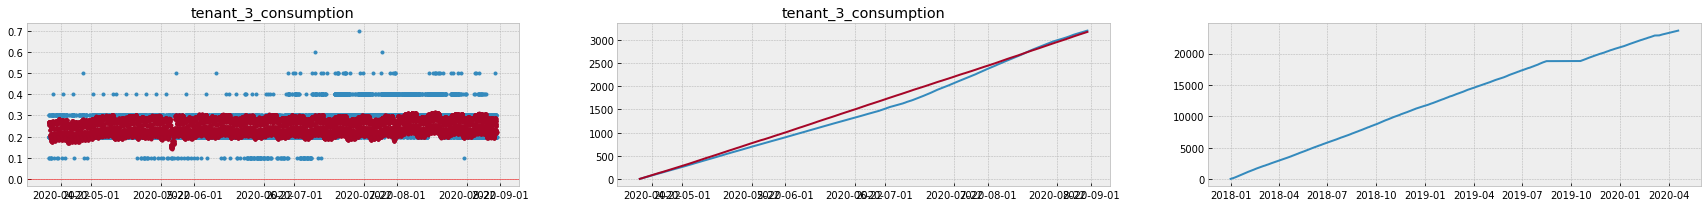

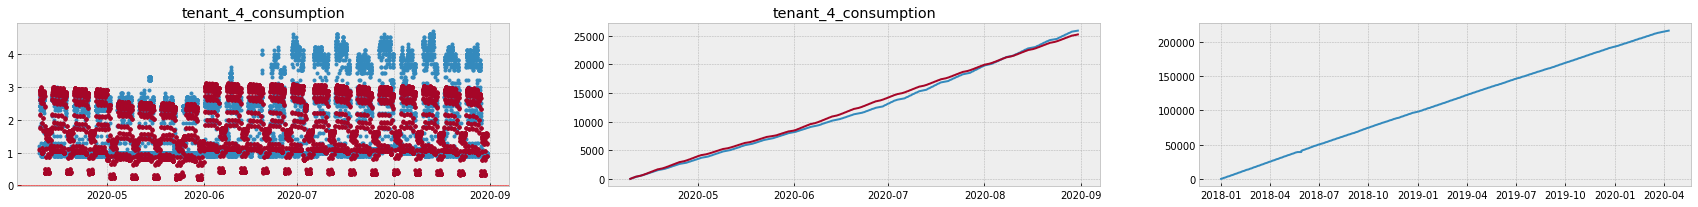

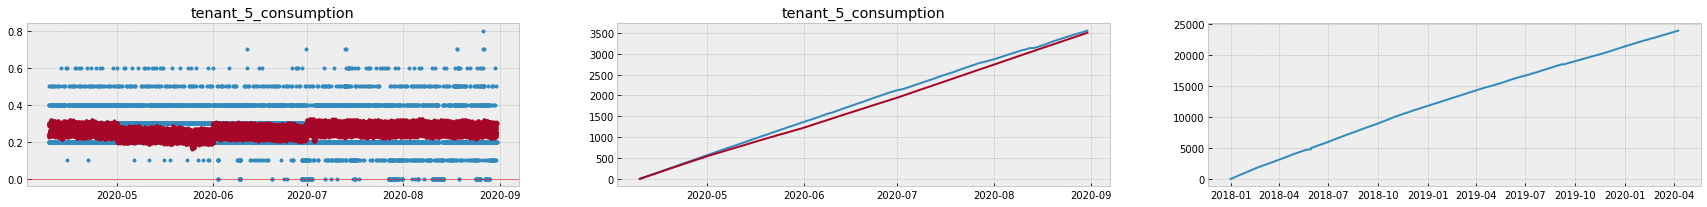

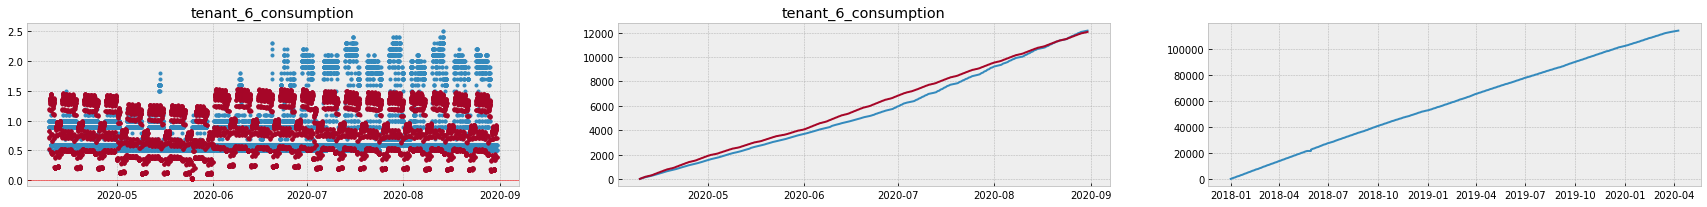

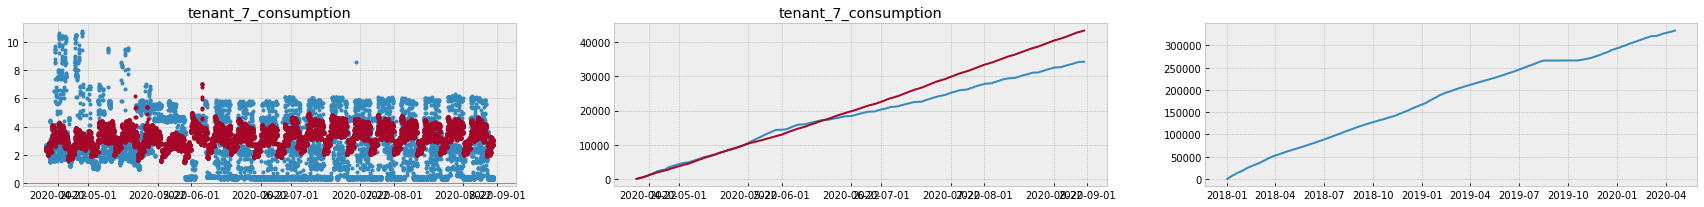

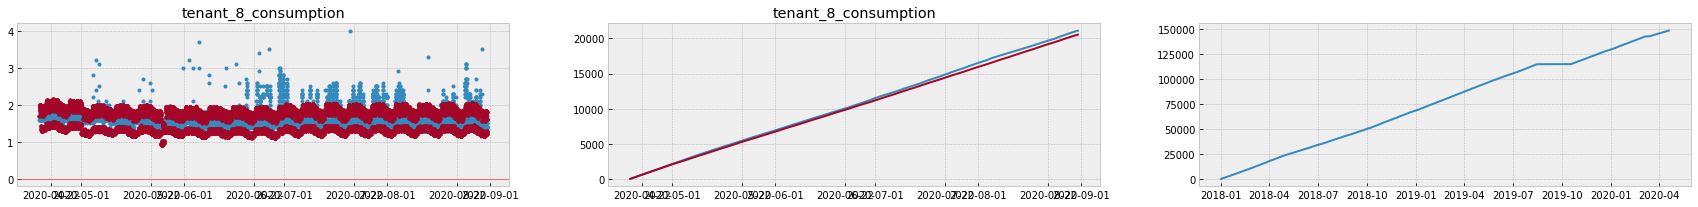

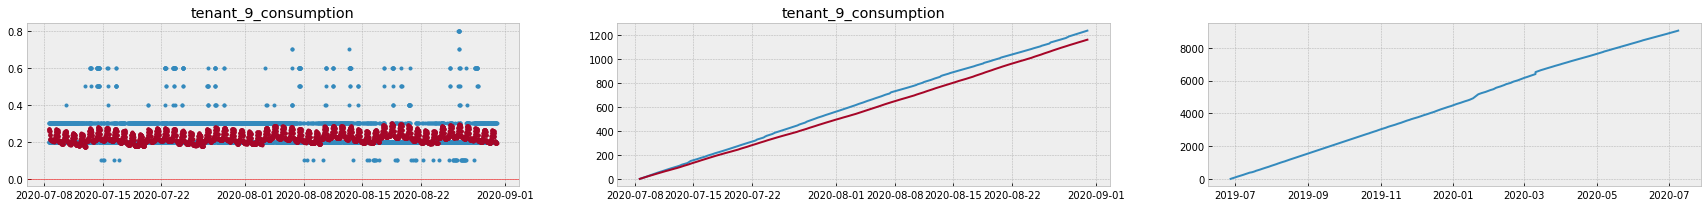

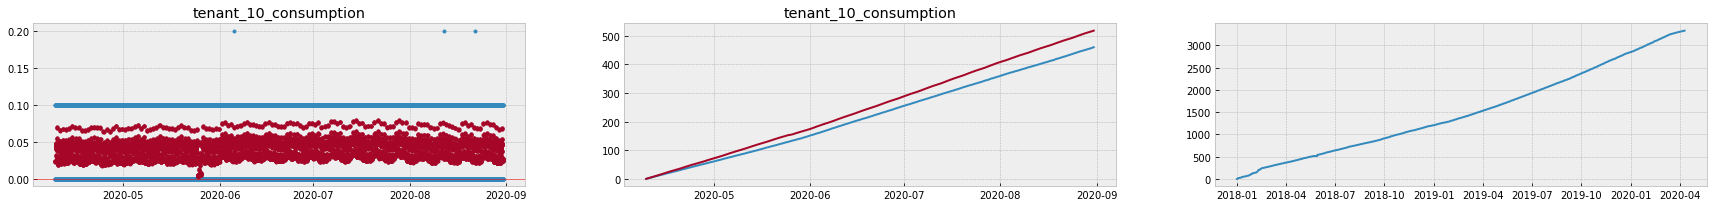

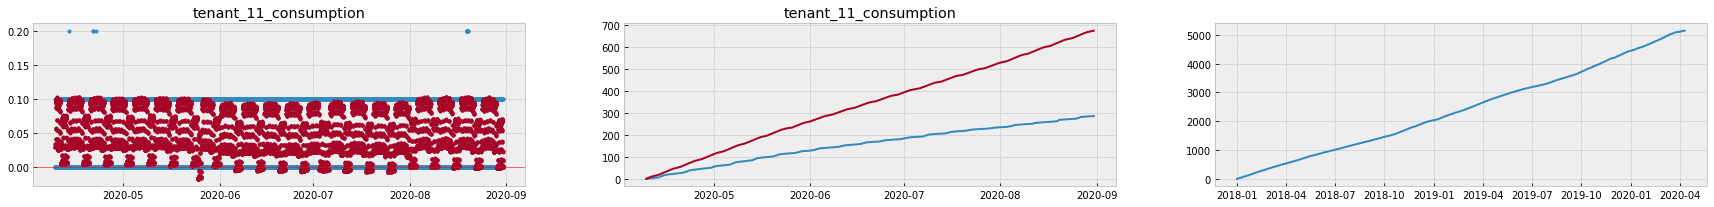

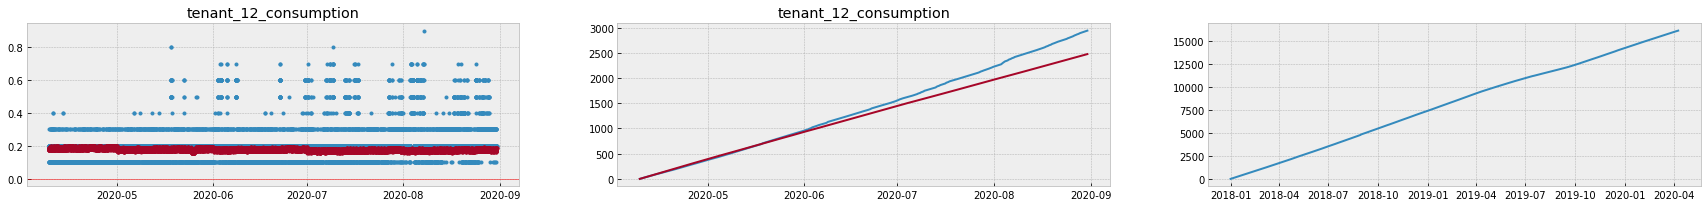

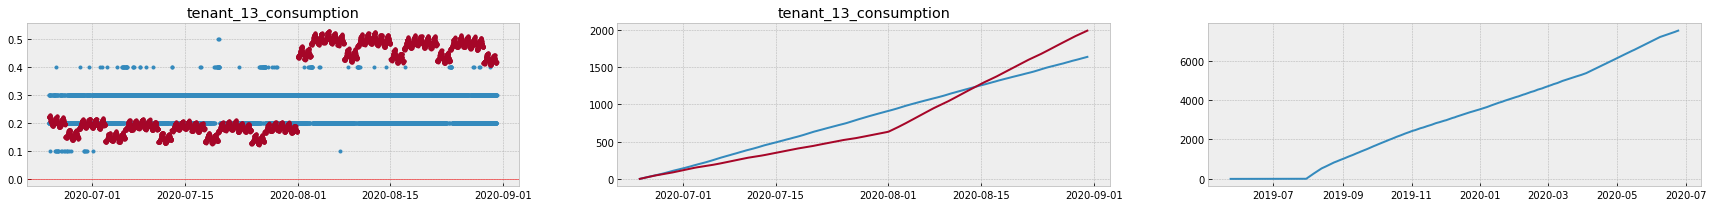

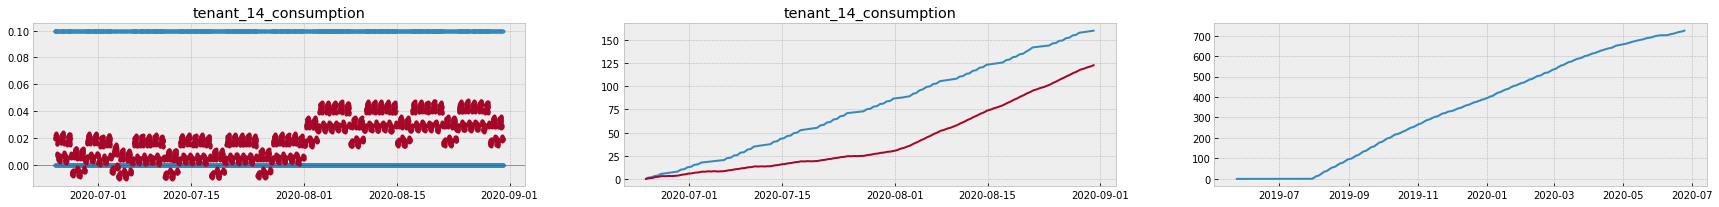

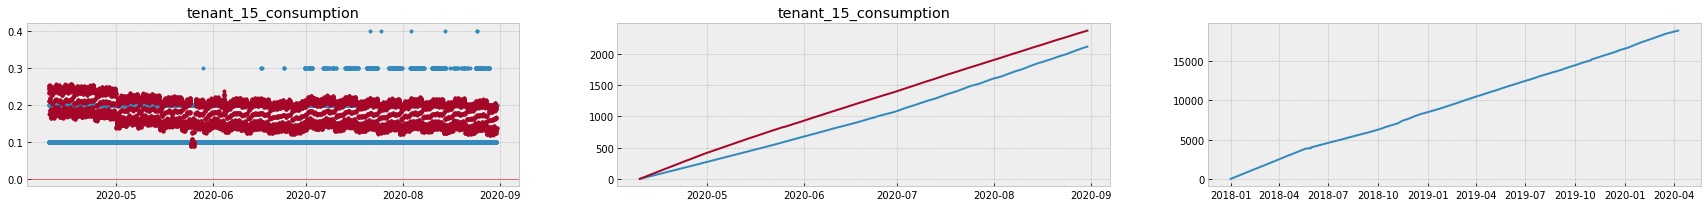

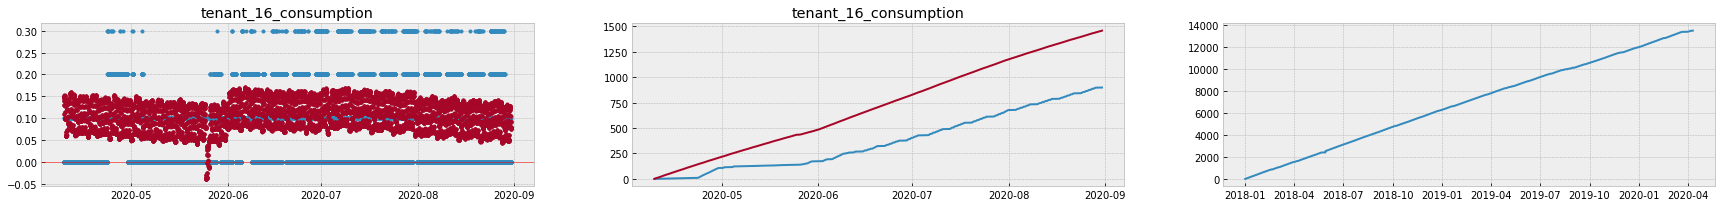

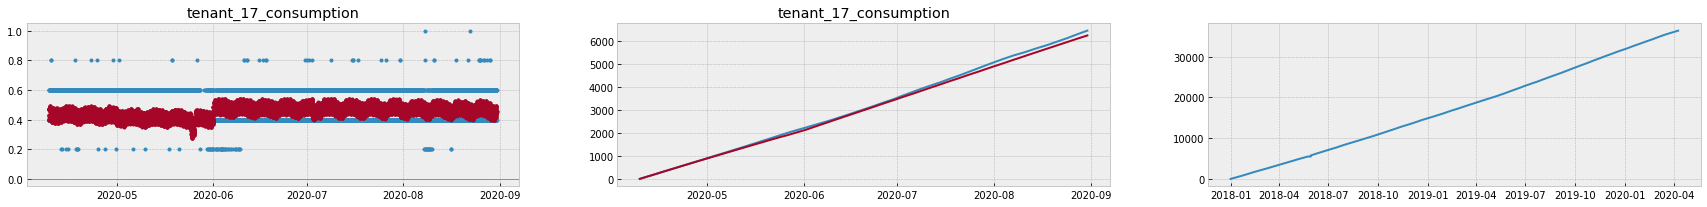

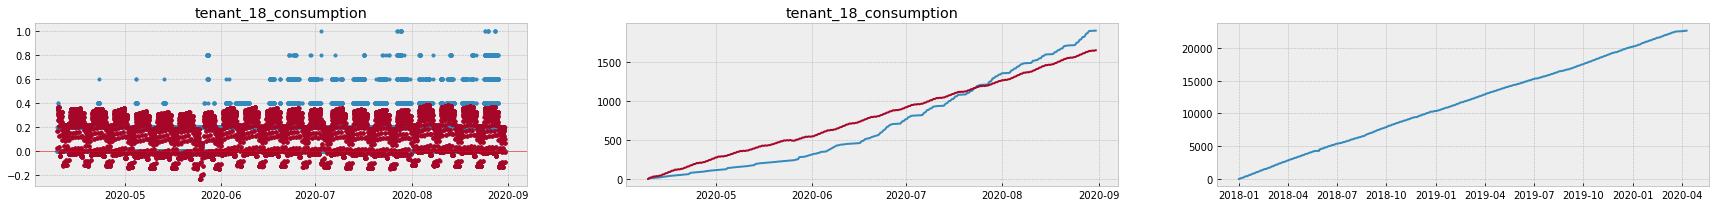

,tenant,rmse,std
0,1,0.197517,0.174501
1,2,0.270823,0.251619
2,3,0.065328,0.036671
3,4,0.673955,0.867855
4,5,0.098589,0.030028
5,6,0.402171,0.409410
6,7,1.896622,0.718594
7,8,0.308111,0.301718
8,9,0.080047,0.028902
9,10,0.049202,0.013221


In [147]:
df_error = pd.DataFrame(columns=['tenant', 'rmse', 'std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'entries', 'has_entries_data', 'day',
                    'year_2018', 'year_2019', 'year_2020',
                    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                    'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                    'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                    'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'quater_0',
                    'quater_1', 'quater_2', 'quater_3', 'weekday_0', 'weekday_1',
                    'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                    'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                    'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night', 
                    test_col]]
    #df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    
    df = df.dropna(subset=[test_col]).fillna(0)
    #print(df.shape, df[test_col].first_valid_index(), df[test_col].last_valid_index())
    test_size = 0.15
    test_index = int(len(df)*(1-test_size))

    X_train = df.drop(test_col, axis = 1).iloc[:test_index]
    y_train = df[test_col].iloc[:test_index]
    X_test = df.drop(test_col, axis = 1).iloc[test_index:]
    y_test = df[test_col].iloc[test_index:]

    #print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    ridge = Ridge(alpha=0.15, normalize=True) 
    ridge.fit(X_train, y_train)
    y_predict = ridge.predict(X_test)
    df_error.loc[i-1] = [str(i)] + list(error(y_test, y_predict))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30, 3))
    ax1.plot(X_test.index, np.expm1(y_test), '.')
    ax1.plot(X_test.index, np.expm1(y_predict), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title(test_col)

    ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
    ax2.set_title(test_col) 
    
    ax3.plot(X_train.index, np.expm1(y_train).cumsum(), '-')
    #ax3.set_title(test_col) 
    
    plt.show()
df_error.loc[i] = ['mean', df_error['rmse'].mean(), df_error['std'].mean()]
df_error

In [ ]:
"""from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings 

df_error = pd.DataFrame(columns=['tenant', 'rmse', 'std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'entries', 'has_entries_data', 'day',
                    'year_2018', 'year_2019', 'year_2020',
                    #'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    #'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    #'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                    #'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                    #'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                    #'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                    #'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                    #'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                    #'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                    'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night', 
                    test_col]]
    #df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    
    df = df.dropna(subset=[test_col]).fillna(0)
    #print(df.shape, df[test_col].first_valid_index(), df[test_col].last_valid_index())
    
    test_size = 0.15
    test_index = int(len(df)*(1-test_size))
    X_train = df.drop(test_col, axis = 1).iloc[:test_index]
    y_train = df[test_col].iloc[:test_index]
    X_test = df.drop(test_col, axis = 1).iloc[test_index:]
    y_test = df[test_col].iloc[test_index:]
    #print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    warnings.filterwarnings('ignore')
    elastic_net = ElasticNet()
    tscv = TimeSeriesSplit(n_splits=5)
    ratio = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    enet_alpha = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
    
    param_grid = {'l1_ratio': ratio, 'alpha': enet_alpha}
    gm_cv = GridSearchCV(elastic_net, param_grid, cv=tscv)
    gm_cv.fit(X_train, y_train)
    y_predict = gm_cv.predict(X_test)
    df_error.loc[i-1] = [str(i)] + list(error(y_test, y_predict))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 3))
    ax1.plot(X_test.index, np.expm1(y_test), '.')
    ax1.plot(X_test.index, np.expm1(y_predict), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title(test_col)

    ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
    ax2.set_title(test_col) 
    
    #ax3.plot(X_train.index, np.expm1(y_train).cumsum(), '-')
    #ax3.set_title(test_col) 
    
    plt.show()
df_error.loc[i] = ['mean', df_error['rmse'].mean(), df_error['std'].mean()]
df_error"""

In [155]:
from sklearn.ensemble import GradientBoostingRegressor

df_error = pd.DataFrame(columns=['tenant', 'rmse', 'std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'entries', 'has_entries_data', 'day',
                    'year_2018', 'year_2019', 'year_2020',
                    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                    'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                    'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                    'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                    'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                    'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                    'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night', 
                    test_col]]
    #df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    
    df = df.dropna(subset=[test_col]).fillna(0)
    #print(df.shape, df[test_col].first_valid_index(), df[test_col].last_valid_index())
    
    test_size = 0.15
    test_index = int(len(df)*(1-test_size))
    X_train = df.drop(test_col, axis = 1).iloc[:test_index]
    y_train = df[test_col].iloc[:test_index]
    X_test = df.drop(test_col, axis = 1).iloc[test_index:]
    y_test = df[test_col].iloc[test_index:]
    #print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    gb = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=5, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber')
    gb.fit(X_train, y_train)
    y_predict = gb.predict(X_test)
    df_error.loc[i-1] = [str(i)] + list(error(y_test, y_predict))
    
    '''fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 3))
    ax1.plot(X_test.index, np.expm1(y_test), '.')
    ax1.plot(X_test.index, np.expm1(y_predict), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title(test_col)

    ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
    ax2.set_title(test_col) 
    
    #ax3.plot(X_train.index, np.expm1(y_train).cumsum(), '-')
    #ax3.set_title(test_col) '''
    
    plt.show()
df_error.loc[i] = ['mean', df_error['rmse'].mean(), df_error['std'].mean()]
df_error

,tenant,rmse,std
0,1,0.167412,0.094320
1,2,0.304085,0.289879
2,3,0.065051,0.036448
3,4,0.590860,0.917943
4,5,0.107732,0.059407
5,6,0.381896,0.367011
6,7,1.796523,1.255463
7,8,0.248229,0.181418
8,9,0.084734,0.023859
9,10,0.048580,0.011980


In [159]:
import warnings
from xgboost import XGBRegressor

df_error = pd.DataFrame(columns=['tenant', 'rmse', 'std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'entries', 'has_entries_data', 'day',
                    'year_2018', 'year_2019', 'year_2020',
                    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                    'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                    'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                    'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                    'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                    'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                    'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night', 
                    test_col]]
    #df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    
    df = df.dropna(subset=[test_col]).fillna(0)
    #print(df.shape, df[test_col].first_valid_index(), df[test_col].last_valid_index())
    
    test_size = 0.15
    test_index = int(len(df)*(1-test_size))
    X_train = df.drop(test_col, axis = 1).iloc[:test_index]
    y_train = df[test_col].iloc[:test_index]
    X_test = df.drop(test_col, axis = 1).iloc[test_index:]
    y_test = df[test_col].iloc[test_index:]
    #print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    warnings.filterwarnings('ignore')
    xgb = XGBRegressor(learning_rate=0.1, n_estimators=500, max_depth=5, 
                   colsample_bytree=1, objective='reg:squarederror',
                   nthread=None, min_child_weight=0, gamma=0, subsample=1, 
                   scale_pos_weight=1, seed=None, reg_alpha=0)
    xgb.fit(X_train, y_train)
    y_predict = xgb.predict(X_test)
    df_error.loc[i-1] = [str(i)] + list(error(y_test, y_predict))
    
    '''fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 3))
    ax1.plot(X_test.index, np.expm1(y_test), '.')
    ax1.plot(X_test.index, np.expm1(y_predict), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title(test_col)

    ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
    ax2.set_title(test_col) 
    
    #ax3.plot(X_train.index, np.expm1(y_train).cumsum(), '-')
    #ax3.set_title(test_col) '''
    
    plt.show()
df_error.loc[i] = ['mean', df_error['rmse'].mean(), df_error['std'].mean()]
df_error

,tenant,rmse,std
0,1,0.165966,0.106774
1,2,0.236469,0.196143
2,3,0.065097,0.038096
3,4,0.653102,0.980811
4,5,0.104586,0.051367
5,6,0.416275,0.362711
6,7,1.937249,1.355673
7,8,0.245766,0.136841
8,9,0.094627,0.050606
9,10,0.049130,0.012806


Fourier

In [203]:
data_ts = merge_data.copy()
data_ts['has_entries_data'] = data_lin['entries'].apply(lambda x: 0 if pd.isnull(x) else 1)
data_ts = data_ts[[#'electric_consumption', 'electric_demand', 'electric_cum_consumption', 'electric_cum_demand',  
        #'steam_consumption', 'steam_demand', 'steam_cum_consumption', 'steam_cum_demand', 
        'temp', 'humidity', 'entries', 'has_entries_data',
        #'all_tenants_consumption', 'all_tenants_cum_consumption', 
        #'year', 'month', 'day', 'hour', 'quater', 'weekday', 'is_weekend', #'daytime_range', #'after_032020',
        'is_holiday', 
        'tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption', 'tenant_4_consumption', 
        'tenant_5_consumption', 'tenant_6_consumption', 'tenant_7_consumption', 'tenant_8_consumption', 
        'tenant_9_consumption', 'tenant_10_consumption', 'tenant_11_consumption', 'tenant_12_consumption', 
        'tenant_13_consumption', 'tenant_14_consumption', 'tenant_15_consumption', 'tenant_16_consumption', 
        'tenant_17_consumption', 'tenant_18_consumption']]
    
data_ts.head()

,temp,humidity,entries,has_entries_data,is_holiday,tenant_1_consumption,tenant_2_consumption,tenant_3_consumption,tenant_4_consumption,tenant_5_consumption,...,tenant_9_consumption,tenant_10_consumption,tenant_11_consumption,tenant_12_consumption,tenant_13_consumption,tenant_14_consumption,tenant_15_consumption,tenant_16_consumption,tenant_17_consumption,tenant_18_consumption
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,9.000,56.100,NaN,0,0,0.4,1.6,0.2,1.3,0.3,...,NaN,0.0,0.0,0.0,NaN,NaN,0.3,0.2,0.2,0.0
2018-01-01 00:30:00,9.000,56.100,NaN,0,0,0.4,1.6,0.2,1.3,0.5,...,NaN,0.1,0.1,0.4,NaN,NaN,0.3,0.1,0.2,0.0
2018-01-01 00:45:00,9.000,56.100,NaN,0,0,0.4,1.5,0.2,1.3,0.4,...,NaN,0.0,0.0,0.2,NaN,NaN,0.2,0.2,0.4,0.2
2018-01-01 01:00:00,9.000,56.100,NaN,0,0,0.3,1.6,0.2,1.3,0.3,...,NaN,0.0,0.0,0.2,NaN,NaN,0.3,0.1,0.4,0.0
2018-01-01 01:15:00,8.975,56.125,NaN,0,0,0.4,1.5,0.3,1.3,0.3,...,NaN,0.1,0.0,0.2,NaN,NaN,0.2,0.2,0.2,0.0


In [204]:
def fourier(df, year_k, week_k, day_k):
    #for k in range(1, year_k+1):
    #    df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365) 
    #    df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365)

    for k in range(1, week_k+1):
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)

    for k in range(1, day_k+1):
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)
        
    for k in range(1, day_k+1):
        df['minute_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.minute/60)
        df['minute_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.minute/60)
    
    return df

In [205]:
data_ts = fourier(data_ts, 3, 3, 3)
data_ts.head()

,temp,humidity,entries,has_entries_data,is_holiday,tenant_1_consumption,tenant_2_consumption,tenant_3_consumption,tenant_4_consumption,tenant_5_consumption,...,hour_sin2,hour_cos2,hour_sin3,hour_cos3,minute_sin1,minute_cos1,minute_sin2,minute_cos2,minute_sin3,minute_cos3
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,9.000,56.100,NaN,0,0,0.4,1.6,0.2,1.3,0.3,...,0.0,1.000000,0.000000,1.000000,1.000000e+00,2.832769e-16,5.665539e-16,-1.0,-1.000000e+00,-1.836970e-16
2018-01-01 00:30:00,9.000,56.100,NaN,0,0,0.4,1.6,0.2,1.3,0.5,...,0.0,1.000000,0.000000,1.000000,5.665539e-16,-1.000000e+00,-1.133108e-15,1.0,3.673940e-16,-1.000000e+00
2018-01-01 00:45:00,9.000,56.100,NaN,0,0,0.4,1.5,0.2,1.3,0.4,...,0.0,1.000000,0.000000,1.000000,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.000000e+00,5.510911e-16
2018-01-01 01:00:00,9.000,56.100,NaN,0,0,0.3,1.6,0.2,1.3,0.3,...,0.5,0.866025,0.707107,0.707107,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
2018-01-01 01:15:00,8.975,56.125,NaN,0,0,0.4,1.5,0.3,1.3,0.3,...,0.5,0.866025,0.707107,0.707107,1.000000e+00,2.832769e-16,5.665539e-16,-1.0,-1.000000e+00,-1.836970e-16


In [206]:
data_ts.columns

Index(['temp', 'humidity', 'entries', 'has_entries_data', 'is_holiday',
       'tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption',
       'tenant_4_consumption', 'tenant_5_consumption', 'tenant_6_consumption',
       'tenant_7_consumption', 'tenant_8_consumption', 'tenant_9_consumption',
       'tenant_10_consumption', 'tenant_11_consumption',
       'tenant_12_consumption', 'tenant_13_consumption',
       'tenant_14_consumption', 'tenant_15_consumption',
       'tenant_16_consumption', 'tenant_17_consumption',
       'tenant_18_consumption', 'week_sin1', 'week_cos1', 'week_sin2',
       'week_cos2', 'week_sin3', 'week_cos3', 'hour_sin1', 'hour_cos1',
       'hour_sin2', 'hour_cos2', 'hour_sin3', 'hour_cos3', 'minute_sin1',
       'minute_cos1', 'minute_sin2', 'minute_cos2', 'minute_sin3',
       'minute_cos3'],
      dtype='object')

In [200]:
'''plt.figure(figsize=(10,5))
plt.plot(test.head(100).index, test.head(100)['hour_sin3'], '.-')
plt.plot(test.head(100).index, test.head(100)['hour_cos3'])
plt.show()'''

"plt.figure(figsize=(10,5))\nplt.plot(test.head(100).index, test.head(100)['hour_sin3'], '.-')\nplt.plot(test.head(100).index, test.head(100)['hour_cos3'])\nplt.show()"

In [210]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm
from statsmodels.tsa.ar_model import ARIMA

df_error = pd.DataFrame(columns=['tenant', 'rmse', 'std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_ts[['temp', 'humidity', 'entries', 'has_entries_data', 'is_holiday',
                  'week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 
                  'hour_sin1', 'hour_cos1', 'hour_sin2', 'hour_cos2', 'hour_sin3', 'hour_cos3', 
                  'minute_sin1', 'minute_cos1', 'minute_sin2', 'minute_cos2', 'minute_sin3', 'minute_cos3', 
                  test_col]]
    #df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    
    df = df.dropna(subset=[test_col]).fillna(0)
    #print(df.shape, df[test_col].first_valid_index(), df[test_col].last_valid_index())
    
    test_size = 0.15
    test_index = int(len(df)*(1-test_size))
    X_train = df.drop(test_col, axis = 1).iloc[:test_index]
    y_train = df[test_col].iloc[:test_index]
    X_test = df.drop(test_col, axis = 1).iloc[test_index:]
    y_test = df[test_col].iloc[test_index:]
    #print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    arima = ARIMA(X_train, order=(2,0,1))
    arima_fit = arima.fit()
    y_predict = autoreg_fit.predict(start=X_test)
    df_error.loc[i-1] = [str(i)] + list(error(y_test, y_predict))
    
    '''fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 3))
    ax1.plot(X_test.index, np.expm1(y_test), '.')
    ax1.plot(X_test.index, np.expm1(y_predict), '.')
    ax1.axhline(0, linewidth = 0.5, color = 'r')
    ax1.set_title(test_col)

    ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
    ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
    ax2.set_title(test_col) 
    
    #ax3.plot(X_train.index, np.expm1(y_train).cumsum(), '-')
    #ax3.set_title(test_col) '''
    
    plt.show()
df_error.loc[i] = ['mean', df_error['rmse'].mean(), df_error['std'].mean()]
df_error

ValueError: Only the univariate case is implemented